# Credit Card Fraud Detection - Introduction

In this notebook, I analyze the dataset and determine the best model to use to predict whether credit card transactions are fraudulent or not fraudulent, which could be helpful to a credit card company, so the company does not lose money to fraudulent transactions. However, if a company classifies too many transactions as fraud, when they are actually legitimate transactions, then the credit card company could irritate customers by needlessly denying their transactions. 

Nearly all of the features have been anonymized, which means that I unfortunately won't be able to what features are most indicative of fraud. I was interested in attempting to solve this problem, because I have a business and accounting background and fraud is something that almost every organization has to deal with, at some level, and I thought this would be an interesting problem to solve.

Fraud detection is an unbalanced classification problem, so the strategies used to transform the data and performance metrics used may be different than for a regular classification problem. Specifically, I will be uses undersampling and oversampling of the training data to try to improve model performance and use the precision score to determine performance (as well as the F1 score, later in the notebook).

The dataset used for this analysis was obtained from: https://www.kaggle.com/mlg-ulb/creditcardfraud

# Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

In [2]:
card = pd.read_csv('creditcard.csv')
card.shape

(284807, 31)

In [3]:
card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
card.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
card['Class'].sum()

492

Stratify the train and test set to ensure that there are fraud transactions in the test set, since this is an unbalanced dataset.

In [3]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(card, card['Class']):
    train = card.loc[train_index]
    test = card.loc[test_index]

In [4]:
print(train['Class'].sum())
print(test['Class'].sum())

394
98


In [5]:
print(train.shape)
print(test.shape)

(227845, 31)
(56962, 31)


In [5]:
X_test = test.loc[:, test.columns != 'Class']
y_test = test['Class']

print(X_test.shape)
print(y_test.shape)

(56962, 30)
(56962,)


# Data Exploration and Visualization

In [30]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94753.589752,0.001101,0.000982,0.002340,0.000832,-0.000046,0.001040,-0.001487,0.001048,-0.000676,...,-0.000697,-0.000167,-0.000217,0.000338,0.000441,0.000743,0.000110,0.000081,88.180572,0.001729
std,47512.314417,1.950349,1.642409,1.508093,1.415063,1.357798,1.324236,1.212443,1.194074,1.098074,...,0.730793,0.725495,0.621364,0.605331,0.521094,0.481871,0.398248,0.320816,247.015822,0.041548
min,0.000000,-46.855047,-63.344698,-33.680984,-5.600607,-40.427726,-23.496714,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54113.000000,-0.921287,-0.598109,-0.886848,-0.848246,-0.693518,-0.767519,-0.554670,-0.208063,-0.643147,...,-0.228490,-0.542083,-0.162023,-0.354468,-0.316587,-0.326511,-0.070812,-0.052949,5.610000,0.000000
50%,84613.000000,0.018739,0.065750,0.180485,-0.019472,-0.053942,-0.274031,0.039741,0.022384,-0.051183,...,-0.029409,0.006964,-0.011301,0.040579,0.017426,-0.051147,0.001249,0.011193,22.000000,0.000000
75%,139333.000000,1.315548,0.805198,1.028314,0.742463,0.611520,0.399481,0.569241,0.327882,0.597372,...,0.186109,0.528218,0.147615,0.440055,0.351061,0.242166,0.090803,0.078218,77.380000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,22.620072,19656.530000,1.000000


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227845 entries, 226579 to 9417
Data columns (total 31 columns):
Time      227845 non-null float64
V1        227845 non-null float64
V2        227845 non-null float64
V3        227845 non-null float64
V4        227845 non-null float64
V5        227845 non-null float64
V6        227845 non-null float64
V7        227845 non-null float64
V8        227845 non-null float64
V9        227845 non-null float64
V10       227845 non-null float64
V11       227845 non-null float64
V12       227845 non-null float64
V13       227845 non-null float64
V14       227845 non-null float64
V15       227845 non-null float64
V16       227845 non-null float64
V17       227845 non-null float64
V18       227845 non-null float64
V19       227845 non-null float64
V20       227845 non-null float64
V21       227845 non-null float64
V22       227845 non-null float64
V23       227845 non-null float64
V24       227845 non-null float64
V25       227845 non-null float64
V2

Looks like none of the data is missing!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D22BB2FC8>,
      dtype=object)

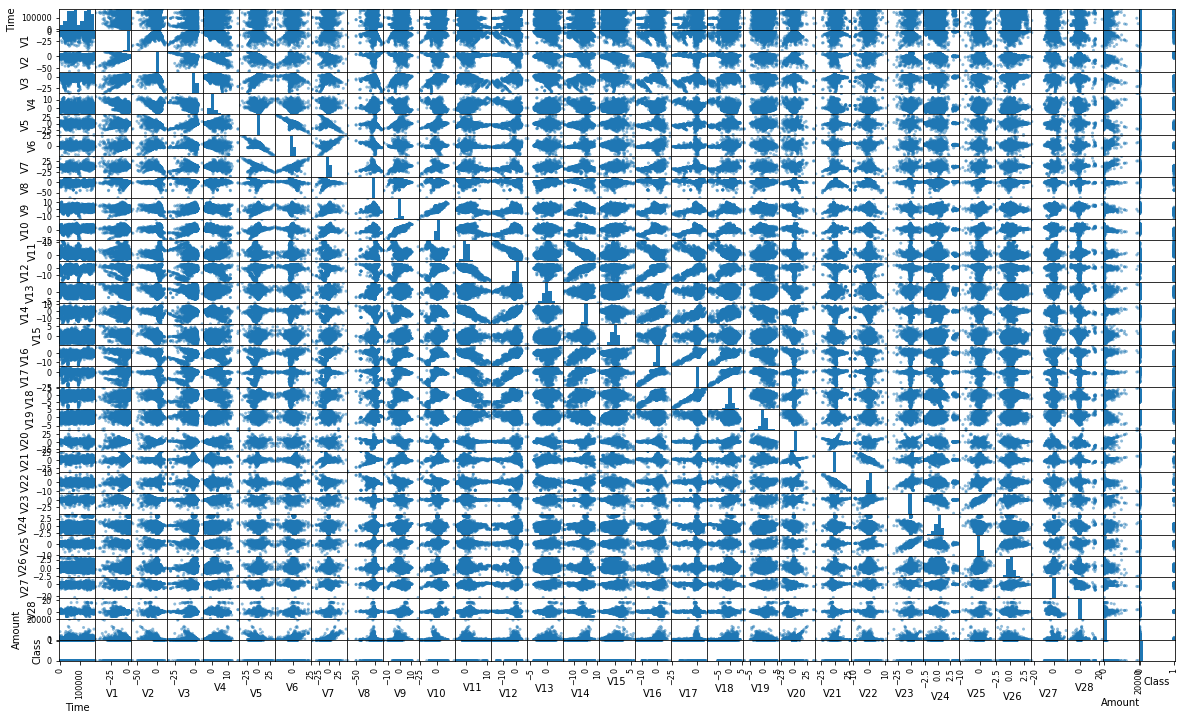

In [33]:
scatter_matrix(train, figsize=(20,12))

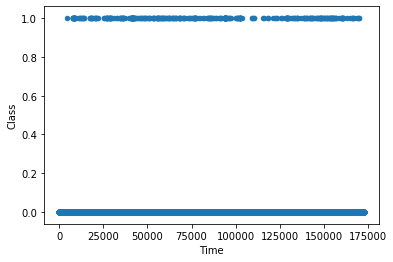

In [19]:
# time feature is number of seconds since the first transaction occurred.
train.plot.scatter('Time', 'Class')

In [10]:
train['Time'].max() / 60 / 60 / 24 # total seconds / seconds in a minute / minutes in an hour / hours in a day

1.9999074074074075

All of the fraudulent transactions seem to be occurring pretty evenly over time, with the time span being only two days in September 2013. However, a plot below shows that there is some variation in the number that occur over time, with the dips most likely occurring at night.

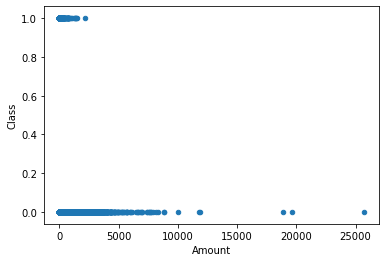

In [10]:
train.plot.scatter('Amount', 'Class')

In [13]:
print('-------- All transactions --------')
print('Average Amt:', train['Amount'].mean())
print('Minimum Amt:', train['Amount'].min())
print('Maximum Amt:', train['Amount'].max())
print('----- Fraud transactions only -----')
print('Average Amt:', train[train['Class']==1]['Amount'].mean())
print('Minimum Amt:', train[train['Class']==1]['Amount'].min())
print('Maximum Amt:', train[train['Class']==1]['Amount'].max())

-------- All transactions --------
Average Amt: 88.1762977023854
Minimum Amt: 0.0
Maximum Amt: 25691.16
----- Fraud transactions only -----
Average Amt: 125.59147208121826
Minimum Amt: 0.0
Maximum Amt: 2125.87


All of the fraud transactions seem to be less than about 2,125, even though the largest transaction is over 25,000. However, the average amount of the fraud transaction is a bit more than all transactions. It is also interesting that some transactions seem to have an amount of 0.0.

In [18]:
print('Count:', train[train['Amount']==0].count()['Amount'])
print('% of total:', train[train['Amount']==0].count()['Amount'] / train['Amount'].count())

Count: 1476
% of total: 0.006478088173977924


It looks like a very small percentage - less than 1% - of the transactions are for an amount of zero. There isn't any information from the dataset's source about why some transactions are zero, and there isn't a logical reason why transactions would be for zero dollars, so it may be helpful to try dropping those transactions while pre-processing. I will probably try models both with the zeros included and excluded to see if it makes a difference in model performance.

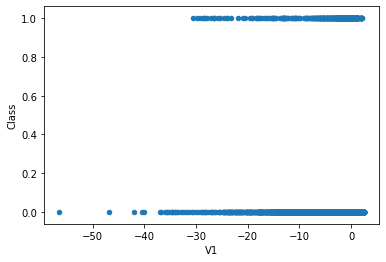

In [8]:
train.plot.scatter('V1', 'Class')

Create a histogram for each feature to looks at each feature's distribution.

C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


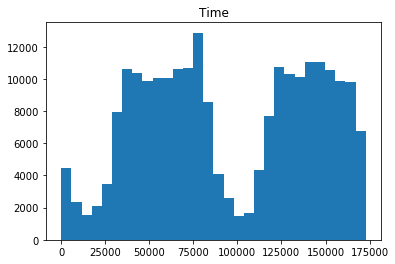

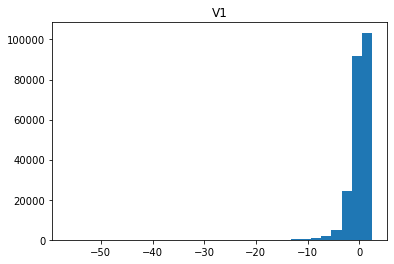

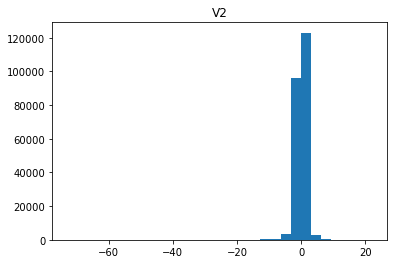

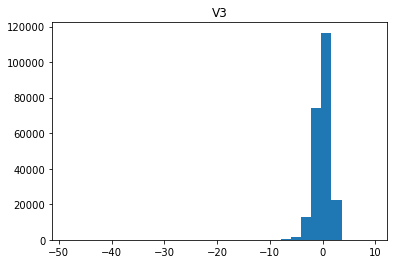

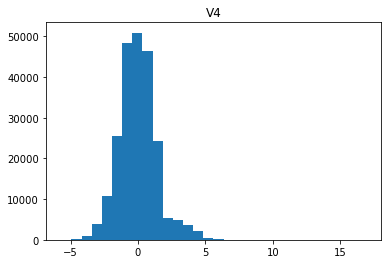

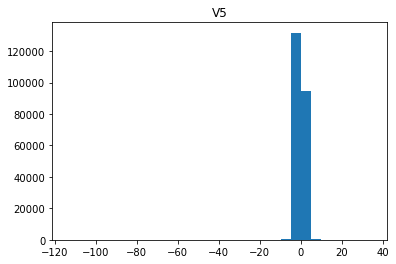

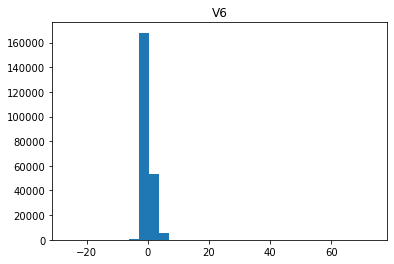

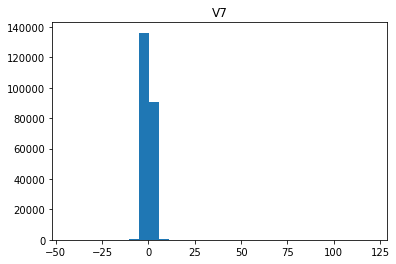

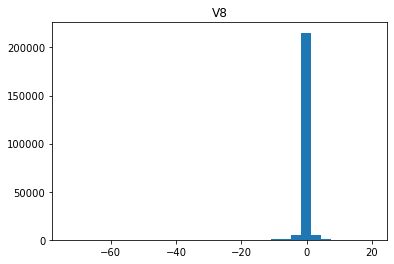

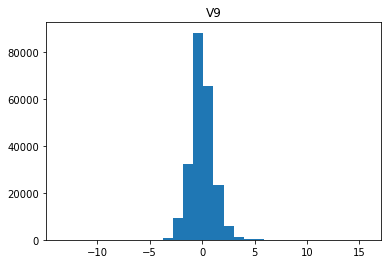

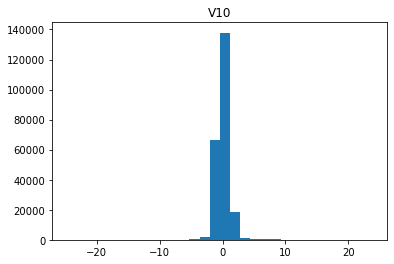

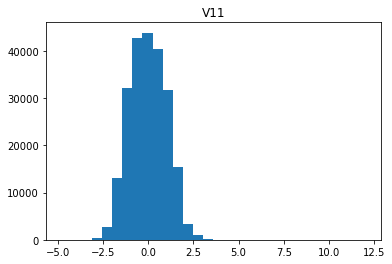

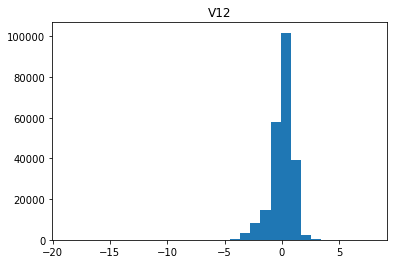

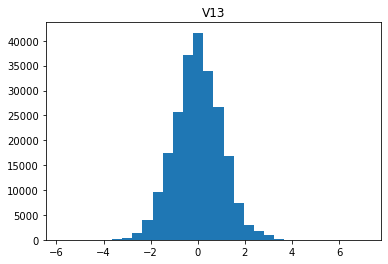

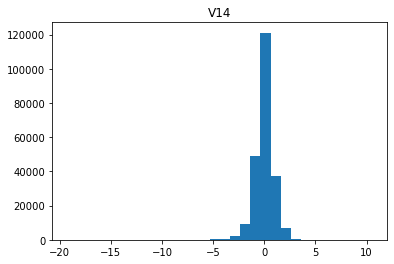

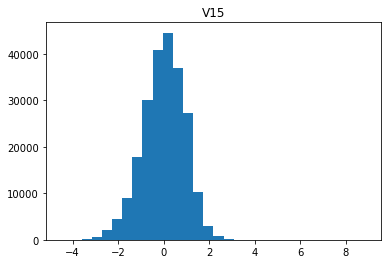

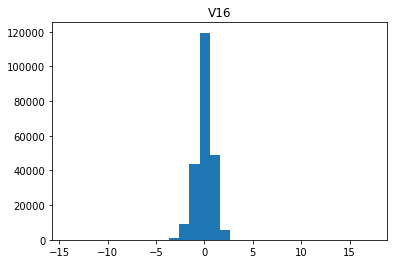

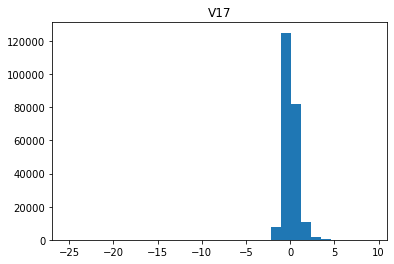

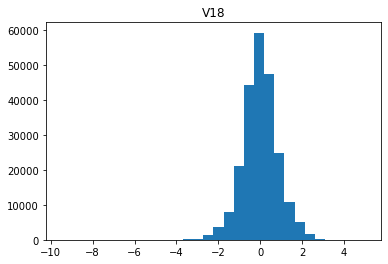

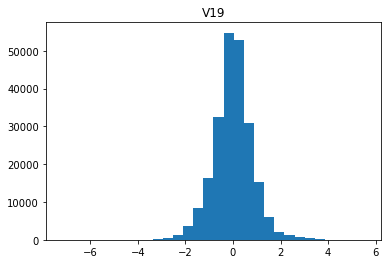

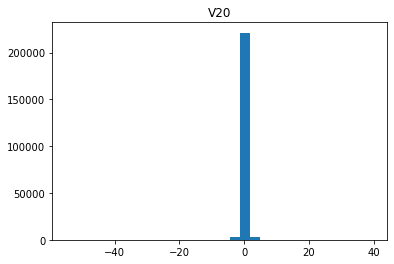

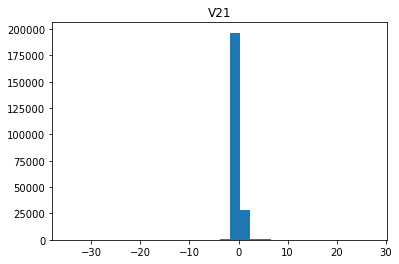

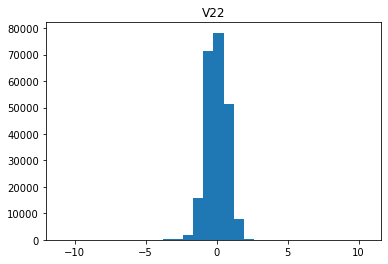

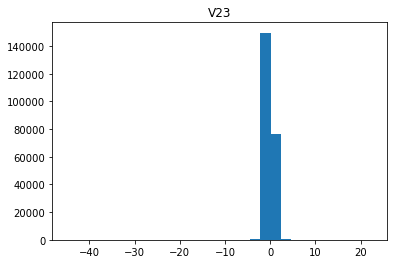

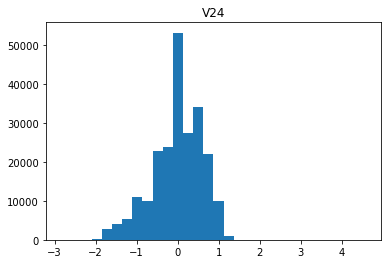

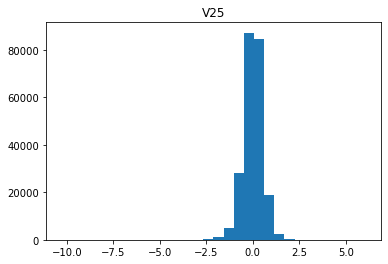

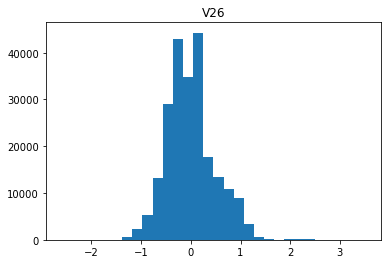

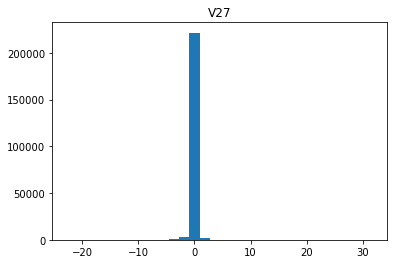

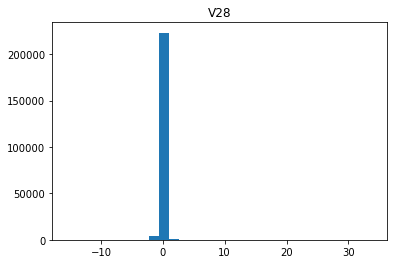

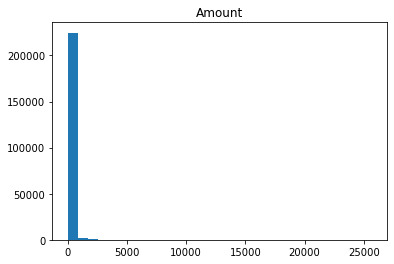

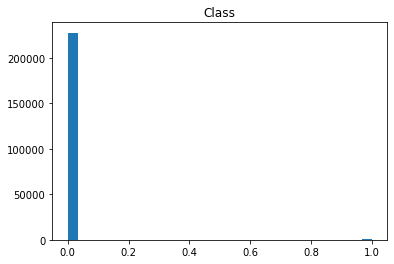

In [26]:
for i in range(len(train.columns)):
    plt.figure(i)
    plt.title(train.columns[i])
    plt.hist(train[train.columns[i]], bins=30)

Most of the feature have pretty close to normal distributions (which makes sense since most were PCA adjusted), but a few of the features have very long tails. The features with long tails could be more important for determining if a transaction is fraudulent.

In [9]:
# determine the correlation of each feature with the Class

corr_matrix = train.corr()
corr_matrix['Class'].sort_values(ascending=False)

Class     1.000000
V11       0.153709
V4        0.135014
V2        0.090586
V21       0.035588
V19       0.032380
V8        0.020552
V20       0.019385
V27       0.016034
V28       0.009810
Amount    0.006211
V26       0.004119
V22       0.002926
V25       0.001618
V23      -0.004169
V15      -0.005705
V13      -0.005861
V24      -0.007483
Time     -0.010564
V6       -0.043334
V5       -0.093578
V9       -0.098247
V1       -0.100041
V18      -0.108732
V7       -0.186184
V16      -0.193826
V3       -0.194135
V10      -0.217894
V12      -0.259989
V14      -0.301054
V17      -0.321937
Name: Class, dtype: float64

Looking at the correlations between each feature and the class it is a part of, none of the feature have a strong correlations as to whether the transaction is fraud or not. However, there are a few that have a modest negative correlation with the transactions class. I've plotted the features below that had greater than +-0.15 correlation.

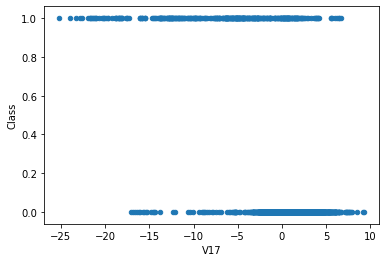

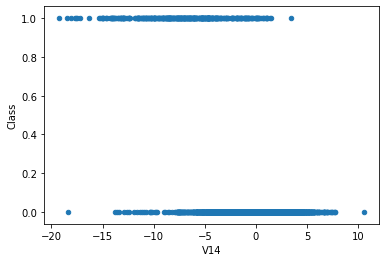

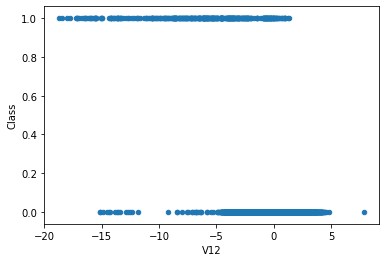

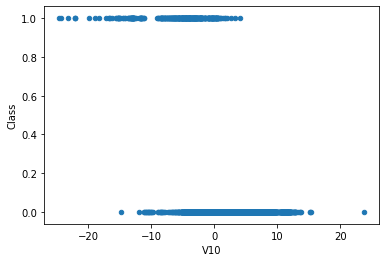

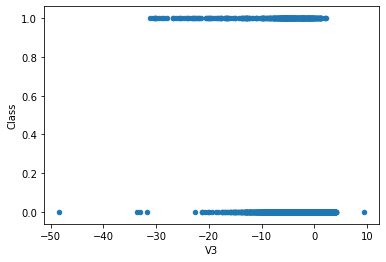

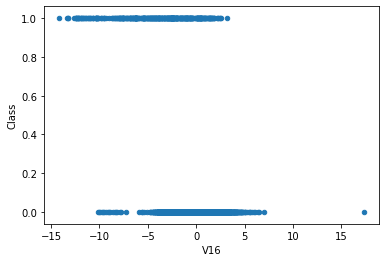

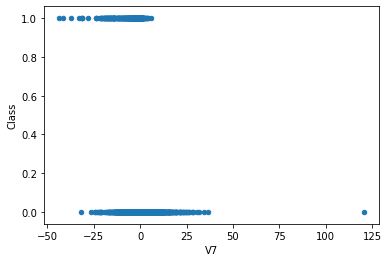

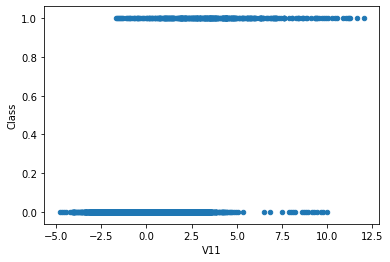

In [11]:
highest_corr = ['V17', 'V14', 'V12', 'V10', 'V3', 'V16', 'V7', 'V11']

for i in range(len(highest_corr)):
    train.plot.scatter(highest_corr[i], 'Class')

Make a sub-dataset consisting of only the fraud transactions, just to see what the features for the fraud class look like using similar plots as above.

In [32]:
fraud = train[train['Class']==1]
fraud.shape

(394, 31)

C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


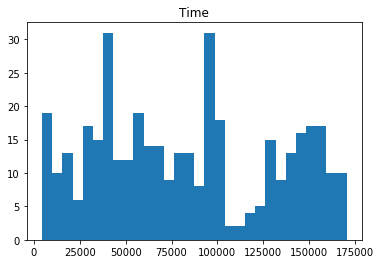

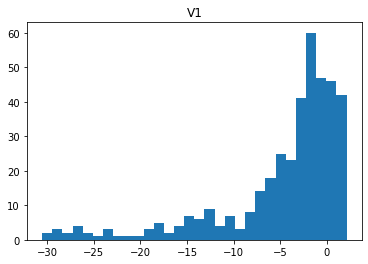

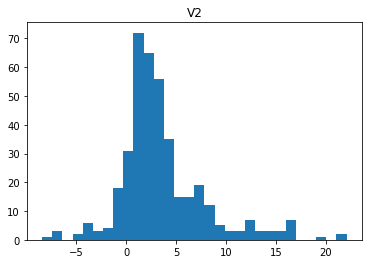

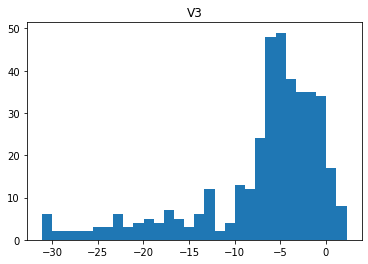

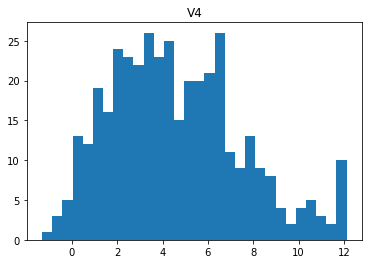

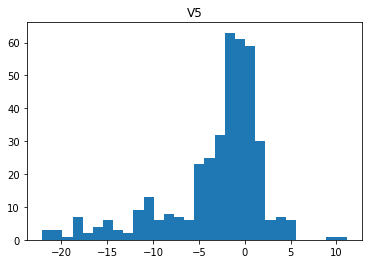

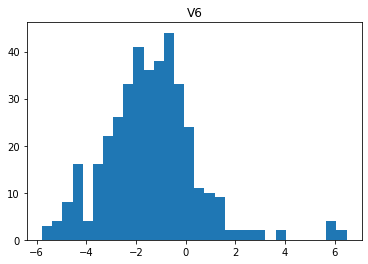

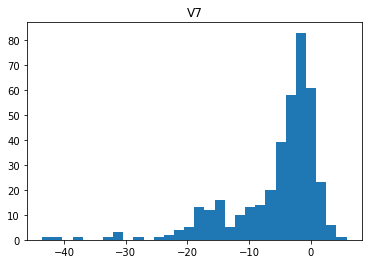

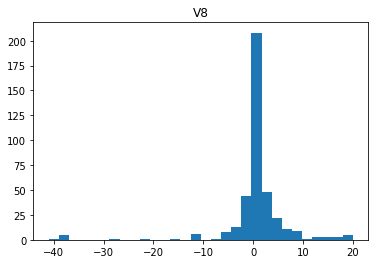

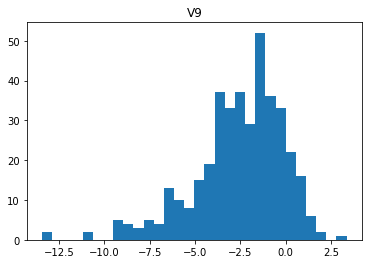

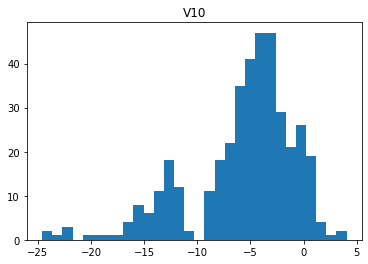

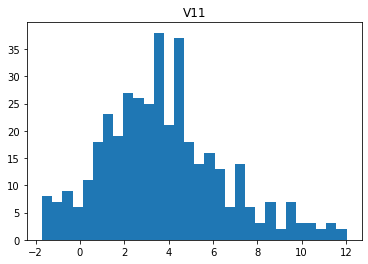

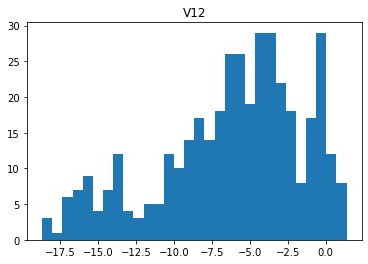

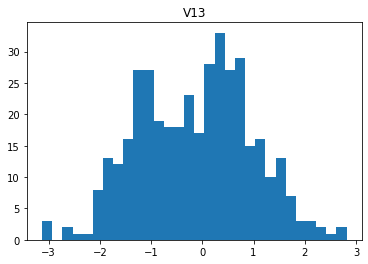

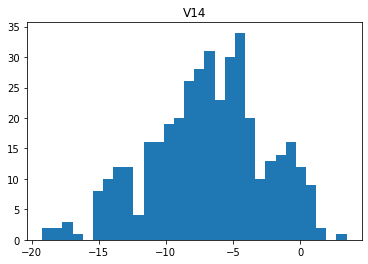

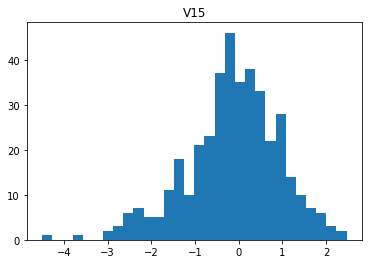

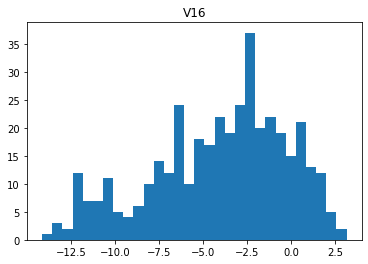

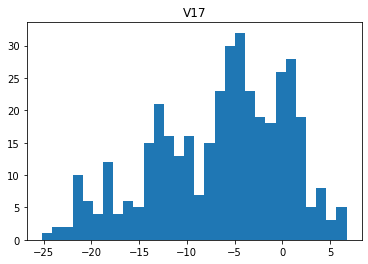

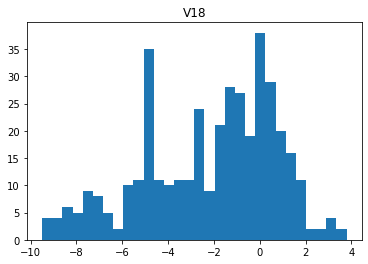

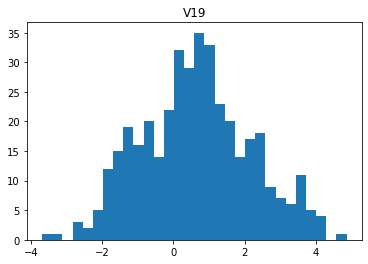

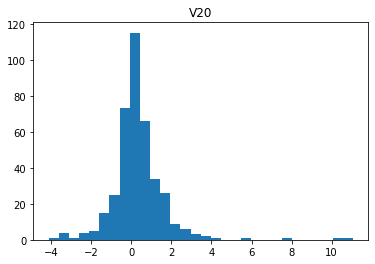

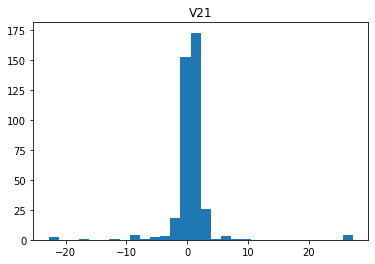

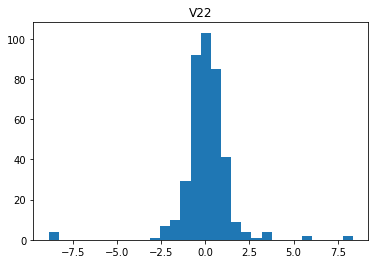

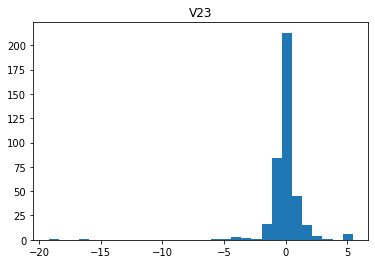

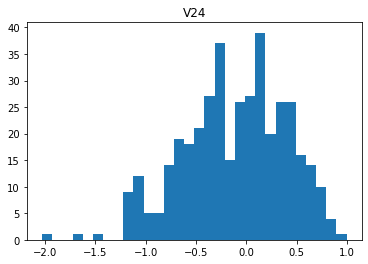

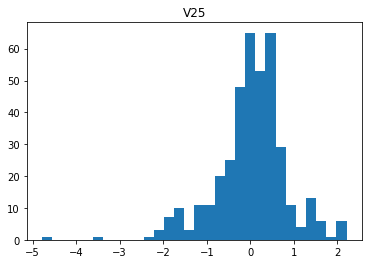

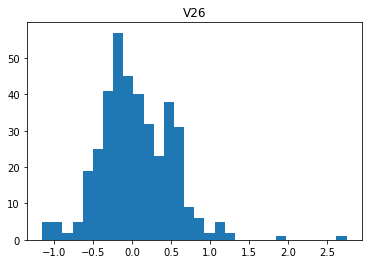

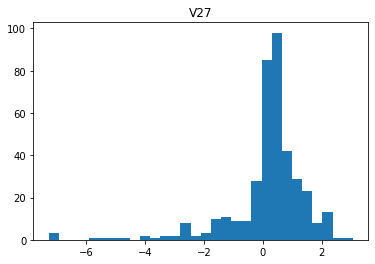

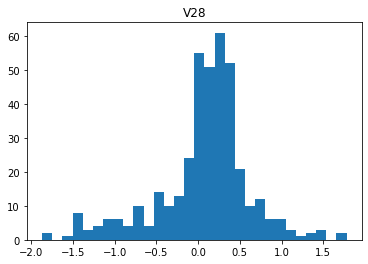

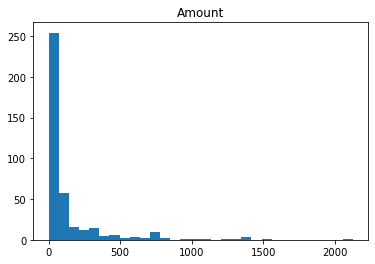

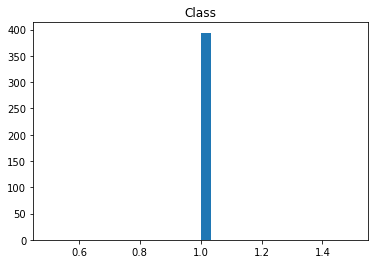

In [33]:
for i in range(len(fraud.columns)):
    plt.figure(i)
    plt.title(fraud.columns[i])
    plt.hist(fraud[fraud.columns[i]], bins=30)

Scanning through, it does appear that some of the features have less of a normal distribution that the entire dataset did. I'll calculate the K-S statistic for each feature of the entire training set compared to the fraud only set to see if there is a large divergence between the two sets. If there is a large difference between the data distribution of the training set and the fraud set, it could mean that that feature is helpful for identifying fraudulent transactions.

In [37]:
for i in range(len(train.columns)):
    print(train.columns[i], '--------------- ')
    print(ks_2samp(train[train.columns[i]], fraud[train.columns[i]]))

Time --------------- 
Ks_2sampResult(statistic=0.15215050128142815, pvalue=2.467722544424311e-08)
V1 --------------- 
Ks_2sampResult(statistic=0.4750766868517459, pvalue=1.5672182485938745e-77)
V2 --------------- 
Ks_2sampResult(statistic=0.6369927213631406, pvalue=4.7863228535915445e-139)
V3 --------------- 
Ks_2sampResult(statistic=0.7091232874606512, pvalue=3.226555715742877e-172)
V4 --------------- 
Ks_2sampResult(statistic=0.7671841764366261, pvalue=1.6803315666051864e-201)
V5 --------------- 
Ks_2sampResult(statistic=0.4374173688520326, pvalue=8.609596260741773e-66)
V6 --------------- 
Ks_2sampResult(statistic=0.4826287084248765, pvalue=5.299422654847005e-80)
V7 --------------- 
Ks_2sampResult(statistic=0.650570802820022, pvalue=5.0974086609527e-145)
V8 --------------- 
Ks_2sampResult(statistic=0.3754862403675667, pvalue=1.3620146042433191e-48)
V9 --------------- 
Ks_2sampResult(statistic=0.580681184878, pvalue=1.2749257628091764e-115)
V10 --------------- 
Ks_2sampResult(statisti

While none of the p-values are large, indicating the two distributions are similar, there are a handful that have very very small p-values. These features are (smaller than e-150) V3, V4, V10, V11, V12, V14, V16, and V17. This probably wasn't a very helpful indicator of which features indicate fraud, since almost all the features had small p-values, but it could be helpful to come back and revisist these features later, when fine-tuning the model.

This would be a good time to explore some feature combinations, and determine if the new features had a higher correlation than the existing features, but since we don't really know what any of the features represent, I will skip past this.

So far, there hasn't been much to indicate which transactions are or are not fraud (it doesn't help that what the features are is unknown). However, there are a few features that seem to have some negative correlation with fraudulent transactions (V17, V14, V12, V10, V3, V16, and V7), the fraud transactions don't seem to be high-dollar amounts, and some of the features' distributions have pretty long tails (which may or may not mean anything). Looking at the features with long tails and the features that showed some correlation, features V17, V14, V12, V7, and V3 appeared to have longer tails and higher correlations.

# Data Preparation and Model Selection

Split the training set into X and y set and make a copy of the X set, so if I mess something up, all is not lost.

In [65]:
X_train = train.loc[:, train.columns != 'Class']
y_train = train['Class']
copy = X_train.copy()
print(copy.shape)
print(y_train.shape)

(227845, 30)
(227845,)


There isn't necessarily much data prep that needs to be done since there are no missing values, all the features are continuous, and all of the features are standardized (other than Amount, which I will leave as is for now). I will create a second dataset with the transactions that have an amount of zero dropped.

In [7]:
no_zeros = train[train['Amount']>0]
X_train_no_zeros = no_zeros.loc[:, no_zeros.columns != 'Class']
y_train_no_zeros = no_zeros['Class']
copy_no_zeros = X_train_no_zeros.copy()
print(copy_no_zeros.shape)
print(y_train_no_zeros.shape)

(226369, 30)
(226369,)


Create a stratified sample of the training set, so that they models can run in a reasonable amount of time on my computer. Once I've narrowed down my model choices, I'll go back to using the full training set. I will just use the first 10,000 items in the training set for now, which contain 21 fraud transactions.

In [45]:
samp = train.iloc[:10000,:].copy()
X_samp = samp.loc[:,samp.columns != 'Class']
y_samp = samp['Class']
print(X_samp.shape)
print(y_samp.sum())

(10000, 30)
21


First, I'll start with a decision tree classifier. It probably won't result in the best model, but it will be interesting to see which features it thinks are the most important. I'm just going to try out a handful of different models to see what seems to be working and what isn't working, and then pick two or three to work on finetuning later. I will be evaulating all the models based on the precision score.

In [44]:
tree = DecisionTreeClassifier()
tree.fit(X_samp, y_samp)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [60]:
sorted(zip(np.round_(tree.feature_importances_, decimals=4), X_samp.columns), reverse=True)

[(0.5483, 'V11'),
 (0.1179, 'V20'),
 (0.0635, 'V17'),
 (0.0477, 'V7'),
 (0.0477, 'V27'),
 (0.0477, 'V15'),
 (0.0471, 'V12'),
 (0.0429, 'V8'),
 (0.0318, 'V6'),
 (0.0047, 'V14'),
 (0.0006, 'V26'),
 (0.0, 'V9'),
 (0.0, 'V5'),
 (0.0, 'V4'),
 (0.0, 'V3'),
 (0.0, 'V28'),
 (0.0, 'V25'),
 (0.0, 'V24'),
 (0.0, 'V23'),
 (0.0, 'V22'),
 (0.0, 'V21'),
 (0.0, 'V2'),
 (0.0, 'V19'),
 (0.0, 'V18'),
 (0.0, 'V16'),
 (0.0, 'V13'),
 (0.0, 'V10'),
 (0.0, 'V1'),
 (0.0, 'Time'),
 (0.0, 'Amount')]

In [38]:
export_graphviz(tree, 
                out_file=os.path.join(IMAGES_PATH, 'fraud_dec_tree.dot'), 
                feature_names=X_samp.columns, 
                rounded=True, 
                filled=True)
# a nice decision tree viz was downloaded

Looking at the image that was downloaded and the feature importances listed out above, it seems like it finds the features V11, V17, V20, V25, and V14 the most important. Now to measure the accuracy using cross validation and the average precision score.

In [41]:
tree = DecisionTreeClassifier()
scores = cross_val_score(tree, X_samp, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


0.5464333333333333

Not great. Let's see if a random forest classifier can do any better.

In [48]:
forest = RandomForestClassifier()
forest.fit(X_samp, y_samp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
sorted(zip(np.round_(forest.feature_importances_, decimals=4), X_samp.columns), reverse=True)

[(0.1677, 'V14'),
 (0.1334, 'V11'),
 (0.117, 'V10'),
 (0.0899, 'V17'),
 (0.0752, 'V12'),
 (0.0442, 'V16'),
 (0.0306, 'V26'),
 (0.0258, 'V18'),
 (0.0257, 'V20'),
 (0.0243, 'V19'),
 (0.0236, 'V9'),
 (0.0203, 'V4'),
 (0.0194, 'V2'),
 (0.0178, 'V3'),
 (0.0175, 'V15'),
 (0.0169, 'V13'),
 (0.0168, 'V6'),
 (0.0154, 'V27'),
 (0.0149, 'V1'),
 (0.0146, 'V5'),
 (0.0145, 'V7'),
 (0.0114, 'V28'),
 (0.0111, 'V25'),
 (0.0111, 'V21'),
 (0.0108, 'V23'),
 (0.0078, 'V22'),
 (0.0061, 'V8'),
 (0.0056, 'V24'),
 (0.0052, 'Time'),
 (0.0051, 'Amount')]

In [63]:
forest = RandomForestClassifier()
scores = cross_val_score(forest, X_samp, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.0s finished


0.7213333333333333

Not the best, but quite a bit better than the decision tree, which is to be expected. The features the random forest model believed were the most important (above 0.05) were V14, V11, V10, V17, and V12. Next, I'll try a SVM Classifier, but first I'll need to scale/normalzie Time and Amount.

In [54]:
X_samp_c = X_samp.copy()
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_samp_c)
X_samp_scaled = scaler.transform(X_samp_c)
# X_samp_c['Amount'] = std_scale.transform(X_samp_c['Amount'])
# # X_samp_c['Time'] = std_scale.transform(X_samp_c['Time'])
X_samp_scaled.shape

(10000, 30)

In [152]:
pd.DataFrame(X_samp_scaled, columns=X_samp.columns)['Time'].mean()

-1.5063505998114124e-16

In [153]:
svc = SVC()
scores = cross_val_score(svc, X_samp_scaled, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


0.7329772750944323

In [55]:
sgd_clf = SGDClassifier()
scores = cross_val_score(sgd_clf, X_samp_scaled, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


0.6979649861149337

Not bad - I'll use the SGD classifier since it will perform better once I start using the full training set, which will have hundreds of thousands of items. Next, I'm going to try out four algorithms that are designed more specifically for anomaly detection - isolation forest, one class svm, elliptic envelope, and local outlier factor.

In [46]:
# isolation forest

iso_forest = IsolationForest()
scores = cross_val_score(iso_forest, X_samp, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


0.0013320973950003974

In [47]:
# one class svm

one_class = OneClassSVM()
scores = cross_val_score(one_class, X_samp, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s finished


0.011245057305690842

In [48]:
# elliptic envelope (best for data that is normally distributed)

ell_enve = EllipticEnvelope()
scores = cross_val_score(ell_enve, X_samp, y_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\covariance\_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-152.287925516226267 > -174.440518086356349). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning)
C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\covariance\_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-114.442833752638705 > -222.046190485099373). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning)
C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\covariance\_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happ

C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\covariance\_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-176.524359186047661 > -205.658225949106253). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning)
C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\covariance\_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-135.102071713514533 > -135.160684074967094). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning)
C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\covariance\_robust_covariance.py:170: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-147.922225304446414 > -228.331040110609848). Y

0.0014611688768354635

In [52]:
# local outlier factor



lof = LocalOutlierFactor(novelty=True)
scores = cross_val_score(lof, X_samp, y_samp, verbose=1, cv=5, scoring='f1_weighted')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


8.150712440972933e-06

All four models did pretty terrible. Part of the reason may be because the data needs to be transformed more to "better suite" the models, but I am going to drop these models for now.

Next, I'm going to move on to oversampling and then training logistic, SVC, and random forest models to the oversampled dataset.

In [154]:
# put the training data back together
data = pd.concat([X_samp, y_samp], axis=1)

# split into the separate classes
fraud = data[data['Class']==1]
not_fraud = data[data['Class']==0]

print(fraud.shape)
print(not_fraud.shape)

(21, 31)
(9979, 31)


In [155]:
oversampled_fraud = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=42)
oversampled_fraud.shape

(9979, 31)

In [157]:
# put the not fraud and over sampled fraud transactions back together
over_samp = pd.concat([not_fraud, oversampled_fraud])
over_samp.shape

(19958, 31)

In [158]:
# split back into X and y

X_over_samp = over_samp.loc[:, over_samp.columns != 'Class']
y_over_samp = over_samp['Class']

print(X_over_samp.shape)
print(y_over_samp.shape)

(19958, 30)
(19958,)


In [160]:
# logistic regression with oversampled set

logit = LogisticRegression(max_iter=500)
scores = cross_val_score(logit, X_over_samp, y_over_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


0.9912152608751071

In [161]:
# random forest with oversampled set

forest = RandomForestClassifier()
scores = cross_val_score(forest, X_over_samp, y_over_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.2s finished


1.0

In [162]:
# SVM classifier with oversampled set

# standardize data
scaler = StandardScaler(with_mean=True, with_std=True)
X_over_samp_scaled = scaler.fit_transform(X_over_samp)

svc = SVC()
scores = cross_val_score(svc, X_over_samp_scaled, y_over_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


0.9995207985420486

Oversampling the dataset seems to really have helped with every model's precision. Now to try the same three models with undersampling. I'm not expecting this to do too well, since the total dataset is going to be pretty small with undersampling.

In [164]:
undersampled_not_fraud = resample(not_fraud, replace=False, n_samples=len(fraud), random_state=42)
under_samp = pd.concat([fraud, undersampled_not_fraud])
X_under_samp = under_samp.loc[:, under_samp.columns != 'Class']
y_under_samp = under_samp['Class']

print(X_under_samp.shape)
print(y_under_samp.shape)

(42, 30)
(42,)


In [165]:
# logistic regression with oversampled set

logit = LogisticRegression(max_iter=500)
scores = cross_val_score(logit, X_under_samp, y_under_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


0.9008333333333333

In [166]:
# random forest with oversampled set

forest = RandomForestClassifier()
scores = cross_val_score(forest, X_under_samp, y_under_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


0.9766666666666666

In [168]:
# SVM classifier with oversampled set

# standardize data
scaler = StandardScaler(with_mean=True, with_std=True)
X_under_samp_scaled = scaler.fit_transform(X_under_samp)

svc = SVC()
scores = cross_val_score(svc, X_under_samp_scaled, y_under_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


0.9608333333333334

Undersampling defintely performed better than using the orignal set, but not quite as good as oversampling. Since oversampling worked the best, I wanted to try using a simple neural network to see how well it worked before choosing two or three models to work on fine-tuning.

In [175]:
# simple neural network with oversampled set

mlp = MLPClassifier()
scores = cross_val_score(mlp, X_over_samp_scaled, y_over_samp, verbose=1, cv=5, scoring='average_precision')
scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.5s finished


0.9998214893665149

The random forest, SVC (SGD), and MLP models performed the best - with oversampled data. I will spend a little time trying to understand what kinds of transactions they are each misclassifying, to see if there are different types of transactions they are misclassifying, or if it mostly the same transactions (with the potential of creating an ensemble model later).

In [220]:
# random forest - oversampled set

forest = RandomForestClassifier()
forest.fit(X_over_samp, y_over_samp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [221]:
probs = pd.DataFrame(forest.predict_proba(X_over_samp))

In [222]:
idx = probs[(probs[0]<0.9) & (probs[0]>0.1)].index
probs[(probs[0]<0.9) & (probs[0]>0.1)]

,0,1
1453,0.89,0.11
2972,0.69,0.31
6687,0.62,0.38


In [223]:
y_over_samp.iloc[idx]

196832    0
14026     0
12922     0
Name: Class, dtype: int64

In [224]:
# svc - oversampled set

svc = SVC(probability=True)
svc.fit(X_over_samp_scaled, y_over_samp)
probs = pd.DataFrame(svc.predict_proba(X_over_samp_scaled))

idx = probs[(probs[0]<0.9) & (probs[0]>0.1)].index
probs[(probs[0]<0.9) & (probs[0]>0.1)]

,0,1
1435,0.134327,0.865673
5498,0.253227,0.746773
6155,0.257672,0.742328
6327,0.858443,0.141557
7003,0.138833,0.861167


In [225]:
y_samp.iloc[idx]

139316    0
185133    0
229156    0
247449    0
76044     0
Name: Class, dtype: int64

In [215]:
#MLP - oversampled set

mlp = MLPClassifier()
mlp.fit(X_over_samp_scaled, y_over_samp)
probs = pd.DataFrame(mlp.predict_proba(X_over_samp_scaled))

idx = probs[(probs[0]<0.9) & (probs[0]>0.1)].index
probs[(probs[0]<0.9) & (probs[0]>0.1)]

,0,1
1435,0.487399,0.512601
1616,0.809925,0.190075
5170,0.898236,0.101764
5498,0.823736,0.176264
5545,0.855350,0.144650
7003,0.839550,0.160450
7078,0.898365,0.101635
7953,0.880664,0.119336
8399,0.872399,0.127601


In [219]:
y_over_samp.iloc[idx]

102505    0
22808     0
94616     0
151393    0
157207    0
159616    0
143191    0
153361    0
151135    0
Name: Class, dtype: int64

In each case, the models are misclassifying not fraud transactions as fraud. There does appear to be some overlap in transactions that are misclassified - each model missed the transaction at index 1453 - they are probably different enough to move on with fine-tuning each of them.

# Model Fine-tuning

In this section, I'm going to focus on the top three models from before (SGD classifier, random forest classifier, and MLP classifier) to see if I can improve the performance

In [6]:
# split into a training and validation set

X = train.loc[:, train.columns != 'Class']
y = train['Class']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(train, train['Class']):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]
    
print(X_train.shape)
print(X_val.shape)

(182276, 30)
(45569, 30)


In [7]:
# create a function to perform oversampling

def oversample(dataset):
    fraud = dataset[dataset['Class']==1]
    not_fraud = dataset[dataset['Class']==0]

    oversampled_fraud = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=42)
    over_samp = pd.concat([not_fraud, oversampled_fraud])

    X_over_samp = over_samp.loc[:, over_samp.columns != 'Class']
    y_over_samp = over_samp['Class']
    
    return X_over_samp, y_over_samp

In [8]:
# function to calculate my metrics for me

def calc_scores(estimator, X_val, y_val, predict_proba=True):
    y_pred = estimator.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    print('f1 score:', f1)
    
    if predict_proba:
        y_prob = estimator.predict_proba(X_val)
        avg_prec = average_precision_score(y_val, np.argmax(y_prob, axis=1))   
        print('average precision score:', avg_prec)

In [9]:
# create oversample dataset with full training data -- validation set is not oversampled

dataset = pd.concat([X_train, y_train], axis=1)
X_train, y_train = oversample(dataset)

print(X_train.shape)
print(y_train.shape)

(363922, 30)
(363922,)


In [11]:
# train a random forest on the entire training set for a better baseline

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
calc_scores(forest, X_val, y_val)

f1 score: 0.8194444444444445
average precision score: 0.6783356816202819


Not bad - now to see if it can be improved upon.

In [13]:
# see what the random forest model thought were the most important features

sorted(zip(np.round_(forest.feature_importances_, decimals=4), X_train.columns), reverse=True)

[(0.1531, 'V14'),
 (0.1135, 'V4'),
 (0.1128, 'V11'),
 (0.1056, 'V17'),
 (0.1035, 'V10'),
 (0.083, 'V12'),
 (0.0426, 'V3'),
 (0.0393, 'V7'),
 (0.0392, 'V2'),
 (0.0252, 'V16'),
 (0.0223, 'V9'),
 (0.0194, 'V18'),
 (0.0154, 'V8'),
 (0.013, 'V19'),
 (0.0124, 'Amount'),
 (0.0118, 'V20'),
 (0.0115, 'V13'),
 (0.0095, 'V26'),
 (0.0078, 'V5'),
 (0.0077, 'V1'),
 (0.0068, 'V21'),
 (0.0059, 'V6'),
 (0.0059, 'V22'),
 (0.0054, 'Time'),
 (0.0051, 'V28'),
 (0.005, 'V27'),
 (0.0048, 'V25'),
 (0.0045, 'V15'),
 (0.0042, 'V23'),
 (0.0036, 'V24')]

In [29]:
# randomized search with random forest

param_distribs = {
    'n_estimators': [50, 1000],
    'max_depth': [1, 500],
    'min_samples_split': [2, 200],
    'min_samples_leaf': [1, 20],
}

forest_rs = RandomForestClassifier()

rdm_search = RandomizedSearchCV(forest_rs, param_distribs, scoring='average_precision', cv=3, verbose=2, 
                                random_state=42, return_train_score=True)

rdm_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   4.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   4.9s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   4.7s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.6min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.6min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.6min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=20, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=20, max_depth=1, total= 1.6min
[CV] n_estimators=1000, min_samples_split=2, min_samples

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 126.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [30]:
rdm_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 200,
 'min_samples_leaf': 1,
 'max_depth': 500}

In [31]:
calc_scores(rdm_search, X_val, y_val)

f1 score: 0.8309859154929577
average precision score: 0.6998562145332199


These seem to be the best score so far. Next, I'll try dropping the features that the random forest thought were the least important and try retraining - keeping the features with an importance greater than 0.05.

In [33]:
best_features = ['V14', 'V4', 'V11', 'V17', 'V10', 'V12']

X_train_reduced = X_train.loc[:, best_features]

In [34]:
forest_red = RandomForestClassifier()
forest_red.fit(X_train_reduced, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
calc_scores(forest_red, X_val.loc[:, best_features], y_val)

f1 score: 0.8108108108108109
average precision score: 0.6608462291509692


In [37]:
# randomized search with reduced features random forest model

param_distribs = {
    'n_estimators': [50, 1000],
    'max_depth': [1, 500],
    'min_samples_split': [2, 200],
    'min_samples_leaf': [1, 20],
}

forest_red = RandomForestClassifier()

rdm_search = RandomizedSearchCV(forest_red, param_distribs, scoring='average_precision', cv=3, verbose=2, 
                                random_state=42, return_train_score=True)

rdm_search.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   3.0s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   3.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   2.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.1min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.1min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.1min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=20, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=20, max_depth=1, total= 1.3min
[CV] n_estimators=1000, min_samples_split=2, min_samples

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 62.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [38]:
rdm_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 500}

In [40]:
calc_scores(rdm_search, X_val.loc[:, best_features], y_val)

f1 score: 0.8163265306122449
average precision score: 0.6705584244308423


Not bad, but this model (with these parameters) may be starting to overfit the training set a little bit. Earlier, I ran a randomized search with a random forest model and it found the optimal parameters as the ones below that resulted in the scores below the parameters.

In [15]:
rdm_search.best_params_

{'n_estimators': 750,
 'min_samples_split': 50,
 'min_samples_leaf': 1,
 'max_depth': 200}

In [16]:
calc_scores(rdm_search, X_val, y_val)

f1 score: 0.8251748251748252
average precision score: 0.6889278189133685


Since the random forest classifier seems to be performing well, I am going to try the extra trees classifier to see if it will perform any better.

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

trees = ExtraTreesClassifier()
trees.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [21]:
calc_scores(trees, X_val, y_val)

f1 score: 0.8029197080291972
average precision score: 0.6607187297060816


In [24]:
sorted(zip(np.round_(trees.feature_importances_, decimals=4), X_train.columns), reverse=True)

[(0.14, 'V14'),
 (0.1264, 'V12'),
 (0.118, 'V4'),
 (0.0953, 'V17'),
 (0.075, 'V16'),
 (0.0659, 'V11'),
 (0.0552, 'V3'),
 (0.0552, 'V10'),
 (0.0491, 'V18'),
 (0.0207, 'V19'),
 (0.0191, 'V9'),
 (0.0163, 'V7'),
 (0.014, 'V1'),
 (0.0133, 'Time'),
 (0.0127, 'V8'),
 (0.0127, 'V6'),
 (0.0124, 'V13'),
 (0.0095, 'V21'),
 (0.0093, 'V26'),
 (0.0091, 'V20'),
 (0.0089, 'Amount'),
 (0.0088, 'V15'),
 (0.0087, 'V22'),
 (0.0075, 'V24'),
 (0.0074, 'V5'),
 (0.007, 'V2'),
 (0.0068, 'V25'),
 (0.0062, 'V27'),
 (0.0058, 'V28'),
 (0.0036, 'V23')]

In [26]:
# randomized search with the extra trees model

param_distribs = {
    'n_estimators': [50, 500],
    'max_depth': [1, 500],
    'min_samples_split': [2, 200],
    'min_samples_leaf': [1, 20],
}

trees_rs = ExtraTreesClassifier()

rdm_search = RandomizedSearchCV(trees_rs, param_distribs, scoring='average_precision', cv=3, verbose=2, 
                                random_state=42, return_train_score=True)

rdm_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   1.6s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   2.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   2.8s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=  24.8s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=  23.1s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=  24.7s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=20, max_depth=1 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=20, max_depth=1, total=  29.2s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=20,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 24.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                        

In [27]:
rdm_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 200,
 'min_samples_leaf': 1,
 'max_depth': 500}

In [28]:
calc_scores(rdm_search, X_val, y_val)

f1 score: 0.8115942028985508
average precision score: 0.6733217211539353


The extra trees model performed pretty good, but not quite as good as the best random forest model, so I'll stick with the random forest model, at least for now.

Now, to scale the data and try an SGD classifier.

In [33]:
# create scaled dataset

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)

In [62]:
# sgd classifier - get a better baseline on oversampled data, using full training set

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
X_val_scaled = scaler.transform(X_val)
calc_scores(sgd_clf, X_val_scaled, y_val, predict_proba=False)

f1 score: 0.10727969348659004


Not a promising start, but I'll see if choosing better parameters helps.

In [75]:
# random search with sgd classifier

param_distribs = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'alpha': [1e-6, 10],
    'max_iter': [100, 10000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [1e-10, 0.1]
}

sgd_clf_rs = SGDClassifier()

rdm_search_sgd = RandomizedSearchCV(sgd_clf_rs, param_distribs, scoring='average_precision', cv=3, verbose=2, 
                                random_state=42, return_train_score=True)

rdm_search_sgd.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] max_iter=10000, loss=squared_hinge, learning_rate=invscaling, eta0=0.1, alpha=1e-06 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_iter=10000, loss=squared_hinge, learning_rate=invscaling, eta0=0.1, alpha=1e-06, total=   0.9s
[CV] max_iter=10000, loss=squared_hinge, learning_rate=invscaling, eta0=0.1, alpha=1e-06 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  max_iter=10000, loss=squared_hinge, learning_rate=invscaling, eta0=0.1, alpha=1e-06, total=   0.7s
[CV] max_iter=10000, loss=squared_hinge, learning_rate=invscaling, eta0=0.1, alpha=1e-06 
[CV]  max_iter=10000, loss=squared_hinge, learning_rate=invscaling, eta0=0.1, alpha=1e-06, total=   0.7s
[CV] max_iter=100, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=1e-06 
[CV]  max_iter=100, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=1e-06, total=   3.5s
[CV] max_iter=100, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=1e-06 
[CV]  max_iter=100, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=1e-06, total=   3.7s
[CV] max_iter=100, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=1e-06 
[CV]  max_iter=100, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=1e-06, total=   3.9s
[CV] max_iter=10000, loss=log, learning_rate=invscaling, eta0=1e-10, alpha=1e-06 
[CV]  max_iter=10000, loss=log, learning_rate=invscaling, eta0=1e-10, alpha=1e-06, total=   0.7s
[CV] max_iter=

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   39.9s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=None, shuffle=True,
                                           tol=0.001, validation_fractio...
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'alpha': [1e-06, 10],
                                        'eta0': [1e-10

In [76]:
rdm_search_sgd.best_params_

{'max_iter': 100,
 'loss': 'hinge',
 'learning_rate': 'adaptive',
 'eta0': 0.1,
 'alpha': 1e-06}

In [77]:
calc_scores(rdm_search_sgd, X_val_scaled, y_val, predict_proba=False)

f1 score: 0.10999225406661502


The model is not doing well with oversampled data, maybe using the orignial data and weighting the classes will help.

In [80]:
# create train and val sets that are not oversampled

X = train.loc[:, train.columns != 'Class']
y = train['Class']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(train, train['Class']):
    X_train_orig = X.iloc[train_index]
    y_train_orig = y.iloc[train_index]
    X_val_orig = X.iloc[val_index]
    y_val_orig = y.iloc[val_index]
    
print(X_train.shape)
print(X_val.shape)

(363922, 30)
(45569, 30)


In [81]:
# scale original data

scaler_sgd = StandardScaler()
X_train_orig_scaled = scaler_sgd.fit_transform(X_train_orig)
X_val_orig_scaled = scaler_sgd.transform(X_val_orig)

In [82]:
sgd_clf_balanced = SGDClassifier(class_weight='balanced')
sgd_clf_balanced.fit(X_train_orig_scaled, y_train_orig)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
calc_scores(sgd_clf_balanced, X_val_orig_scaled, y_val_orig, predict_proba=False)

f1 score: 0.07626208378088078


It looks like the SGD classifier may just not work out. It's possible that outliers are negatively effecting the model. If I have time, I will circle back and try to identify outliers to try and see if it helps this model's performance. But for now, I will move on.

Last, I'll try an MLP classifier.

In [73]:
# MLP - better baseline with oversampled data, full train set

mlp = MLPClassifier(verbose=True)
mlp.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.08761830
Iteration 2, loss = 0.02523206
Iteration 3, loss = 0.01278851
Iteration 4, loss = 0.00779520
Iteration 5, loss = 0.00528373
Iteration 6, loss = 0.00400376
Iteration 7, loss = 0.00316969
Iteration 8, loss = 0.00273540
Iteration 9, loss = 0.00232504
Iteration 10, loss = 0.00201535
Iteration 11, loss = 0.00178847
Iteration 12, loss = 0.00163909
Iteration 13, loss = 0.00141105
Iteration 14, loss = 0.00137286
Iteration 15, loss = 0.00115417
Iteration 16, loss = 0.00111305
Iteration 17, loss = 0.00101911
Iteration 18, loss = 0.00105530
Iteration 19, loss = inf
Iteration 20, loss = 0.00090994
Iteration 21, loss = 0.00078110
Iteration 22, loss = 0.00078534
Iteration 23, loss = 0.00072982
Iteration 24, loss = 0.00074081
Iteration 25, loss = 0.00089308
Iteration 26, loss = 0.00063661
Iteration 27, loss = 0.00065375
Iteration 28, loss = 0.00063107
Iteration 29, loss = 0.00066021
Iteration 30, loss = 0.00061239
Iteration 31, loss = 0.00058373
Iteration 32, loss = 0.0

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [74]:
calc_scores(mlp, X_val_scaled, y_val)

f1 score: 0.7058823529411764
average precision score: 0.49935121864684234


Not the best score so far. I'll try a MLP model with just the best features, as defined earlier to see if the model performs any better.

In [96]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
mlp = MLPClassifier()
mlp.fit(X_train_scaled_df.loc[:, best_features], y_train)

C:\Users\ckell\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [98]:
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train.columns)

calc_scores(mlp, X_val_scaled_df.loc[:, best_features], y_val)

f1 score: 0.31351351351351353
average precision score: 0.1467916934925139


Even worse performance..

Summary of how the models performed:

random forest - oversampled data: f1 score: 0.8309, average precision score: 0.6998 

random forest - oversamp, reduced features: f1 score: 0.8163, average precision score: 0.6705

extra trees - oversampled data: f1 score: 0.8115, average precision score: 0.6733

SGD classifier - oversampled data: f1 score: 0.1099

SGD classifier - original data: f1 score: 0.0762

MLP classifier - oversampled data (w/o rand search): f1 score: 0.7058 average precision score: 0.4993

MLP classifier - oversamp, reduced features: f1 score: 0.3135 average precision score: 0.1467

The random forest model with oversampled data seems to be my best bet so far. Finally, I'll do a little more feature engineering, as I have time, to see if I can improve the performance of the model.

# Further Feature Engineering

Finally, since the random forest model is my best performing model I will try using training data that has had the transactions with an amount of $0 removed to see if that will boost performance. Even if zero amount transactions are classifier as fraud, it shouldn't necessarily be a problem, because the company would not be out any money.

In [10]:
# remove transactions with amount of zero

train_concat = pd.concat([X_train, y_train], axis=1)

train_concat = train_concat[train_concat['Amount'] > 0]

X_train_no_zeros = train_concat.loc[:, train_concat.columns != 'Class']
y_train_no_zeros = train_concat['Class']

X_train_no_zeros.shape

(352350, 30)

Around 10,000 transactions removed because they had an amount of zero.

In [19]:
forest_zeros = RandomForestClassifier()
forest_zeros.fit(X_train_no_zeros, y_train_no_zeros)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
calc_scores(forest_zeros, X_val, y_val)

f1 score: 0.8368794326241135
average precision score: 0.7111371390440341


In [13]:
# most important features

sorted(zip(np.round_(forest_zeros.feature_importances_, decimals=4), X_train.columns), reverse=True)

[(0.1823, 'V14'),
 (0.1322, 'V10'),
 (0.1089, 'V12'),
 (0.0879, 'V17'),
 (0.0854, 'V4'),
 (0.0623, 'V3'),
 (0.0583, 'V11'),
 (0.0549, 'V16'),
 (0.0229, 'V9'),
 (0.0186, 'V18'),
 (0.0178, 'V7'),
 (0.016, 'V2'),
 (0.0153, 'V8'),
 (0.013, 'V1'),
 (0.0126, 'V21'),
 (0.0126, 'Amount'),
 (0.0122, 'V20'),
 (0.0121, 'V19'),
 (0.0107, 'V13'),
 (0.0099, 'V26'),
 (0.007, 'V27'),
 (0.0065, 'V5'),
 (0.0062, 'V22'),
 (0.0057, 'V25'),
 (0.0054, 'Time'),
 (0.0053, 'V15'),
 (0.005, 'V6'),
 (0.0047, 'V23'),
 (0.0045, 'V24'),
 (0.0038, 'V28')]

In [14]:
# remove zero amounts from validation set and recalculate scores

val_concat = pd.concat([X_val, y_val], axis=1)

val_concat = val_concat[val_concat['Amount']>0]

X_val_no_zeros = val_concat.loc[:, val_concat.columns != 'Class']
y_val_no_zeros = val_concat['Class']

calc_scores(forest_zeros, X_val_no_zeros, y_val_no_zeros)

f1 score: 0.8529411764705883
average precision score: 0.7356759301122736


In [20]:
y_pred = forest_zeros.predict(X_val_no_zeros)
recall_score(y_val_no_zeros, y_pred)

0.7733333333333333

In [15]:
param_distribs = {
    'n_estimators': [50, 1000],
    'max_depth': [1, 500],
    'min_samples_split': [2, 200],
    'min_samples_leaf': [1, 20],
}

forest_zeros = RandomForestClassifier()

rdm_search_forest = RandomizedSearchCV(forest_zeros, param_distribs, scoring='average_precision', cv=3, verbose=2, 
                                random_state=42, return_train_score=True)

rdm_search_forest.fit(X_train_no_zeros, y_train_no_zeros)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   4.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   4.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=1, total=   4.7s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.9min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.9min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_depth=1, total= 1.8min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=20, max_depth=1 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=20, max_depth=1, total= 1.9min
[CV] n_estimators=1000, min_samples_split=2, min_samples

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 123.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [16]:
rdm_search_forest.best_params_

{'n_estimators': 1000,
 'min_samples_split': 200,
 'min_samples_leaf': 1,
 'max_depth': 500}

In [17]:
calc_scores(rdm_search_forest, X_val_no_zeros, y_val_no_zeros)

f1 score: 0.832116788321168
average precision score: 0.699107142475552


It appears that the best model is the random forest model, with default parameters, and the zero amounts removed. This model had a F1 score of 0.8529, precision score of 0.7356 and recall score of 0.7733. This precision score means that the model is classifying about 74% of the transactions it believes are fraud correctly (i.e. how valid the results are). Additionally, the recall score means that the model is correcting classying about 77% of the actual fraud transactions (i.e. how complete the results are). Finally, a confusion matrix to visualize the classification results.

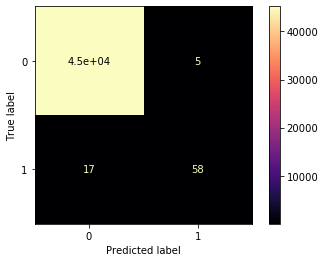

In [24]:
plot_confusion_matrix(forest_zeros, X_val_no_zeros, y_val_no_zeros, cmap='magma')

Finally, I'll train the model on the combined training and validation sets, since training on a little more data should help the model's performance a little more.

In [25]:
# function to remove transactions with amount of zero

def remove_zeros(X, y):
    concat = pd.concat([X, y], axis=1)
    concat = concat[concat['Amount'] > 0]

    X_no_zeros = concat.loc[:, concat.columns != 'Class']
    y_no_zeros = concat['Class']
    
    return X_no_zeros, y_no_zeros

In [26]:
# upsample, remove zeros, and refit model to full training set

X_train_full, y_train_full = oversample(train)
X_train_full_nozero, y_train_full_nozero = remove_zeros(X_train_full, y_train_full)

forest_zeros.fit(X_train_full_nozero, y_train_full_nozero)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Conclusion

In [27]:
# remove zeros from test set and predict y values

X_test_nozero, y_test_nozero = remove_zeros(X_test, y_test)
y_pred = forest_zeros.predict(X_test_nozero)

In [31]:
# calculate generalization error

print('precision:', average_precision_score(y_test_nozero, y_pred))
print('recall:', recall_score(y_test_nozero, y_pred))
print('f1 score:', f1_score(y_test_nozero, y_pred))

precision: 0.7435967459884684
recall: 0.7741935483870968
f1 score: 0.8571428571428571


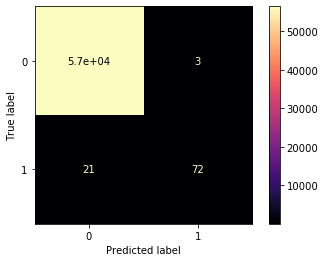

In [30]:
plot_confusion_matrix(forest_zeros, X_test_nozero, y_test_nozero, cmap='magma')

Pretty similar results compared to the training/validation set scores.

If I had more time, I would've liked to explore each feature a little more, with the goal of removing outliers to try to help various models' performance.